# 一个简单的PyDESeq2工作流

我们首先导入所需的包，并设置一个可选的路径来保存结果

In [1]:
import os
import pickle as pkl

import sys
sys.path.insert(0, "/slurm/home/admin/nlp/DL/97-bioinformatics/bio_package/pydeseq2")
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

SAVE = False  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be saved
    OUTPUT_PATH = "/slurm/home/admin/nlp/DL/results/synthetic_example"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

为了执行差异表达分析（DEA），PyDESeq2 需要两种类型的输入：
- 形状为“样本数”x“基因数”的计数矩阵，包含读取计数（非负整数），
- 形状为“样本数”x“变量数”的元数据（或“列”数据），包含将用于将数据拆分为群组的样本注释。

为了说明所需的数据格式，我们加载了一个合成示例数据集，该数据集可以通过 PyDESeq2 的 API `utils.load_example_data()`使用获得。您可以将其替换为您自己的数据集。

In [4]:
import pandas as pd 

# counts_df = load_example_data(
#     modality="raw_counts",
#     dataset="synthetic",
#     debug=False,
# )

# metadata = load_example_data(
#     modality="metadata",
#     dataset="synthetic",
#     debug=False,
# )

# print(counts_df)


count_file = "../../data/test_counts.csv"
counts_df = pd.read_csv(count_file,index_col=0).T
counts_df

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10
sample1,12,21,4,130,18,0,16,54,49,3
sample2,1,44,2,63,11,10,70,32,57,9
sample3,4,4,11,180,21,3,28,34,65,2
sample4,1,10,2,100,44,9,28,16,33,9
sample5,1,11,6,135,16,2,32,29,31,5
...,...,...,...,...,...,...,...,...,...,...
sample96,7,26,3,67,11,4,41,44,54,1
sample97,1,14,3,71,33,5,19,42,25,4
sample98,10,36,2,72,11,2,66,27,16,9
sample99,18,14,3,66,53,11,32,19,79,11


In [5]:
metadata = "../../data/test_metadata.csv"
metadata = pd.read_csv(metadata, index_col=0)
metadata.head()

,condition,group
sample1,A,X
sample2,A,Y
sample3,A,X
sample4,A,Y
sample5,A,X


在此示例中，元数据包含两列，condition和group，代表两种类型的双层注释。在第一部分中，我们将仅使用condition因子 。稍后，我们将看到如何在分析中同时使用condition 和 group因子（[参见多因子分析](https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html#multifactor-ref)）。

## 数据过滤
在继续进行 DEA 之前，最好先对数据进行预处理，例如删除缺少注释的样本并排除表达水平非常低的基因。对于我们的合成数据，这不是必需的，但如果您使用的是真实数据，请不要忘记这一步。为此，您可以使用以下代码。

我们首先移除条件为NaN的样本。如果您正在使用另一个数据集，请不要忘记更改元数据列的条件，以便在分析中用作设计因素。

In [6]:
samples_to_keep = ~metadata.condition.isna()
counts_df = counts_df.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]

> 在设计因子包含NaN项的情况下，PyDESeq2将在初始化DeseqDataSet时抛出错误。

接下来，我们过滤掉读取总数少于10个的基因。再次注意，在这个合成数据集中没有这样的基因。

In [8]:
counts_df.sum(axis=0)

gene1       838
gene2      2259
gene3       485
gene4     10682
gene5      2870
gene6       545
gene7      2966
gene8      4277
gene9      3886
gene10     1170
dtype: int64

In [7]:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

现在我们已经加载并过滤了数据，我们可以继续进行差分分析。

## 单因素分析

在第一个分析中，我们忽略了`group`变量，并使用`condition`列作为我们的设计因子。也就是说，我们比较`condition`B和`condition`A样本的基因表达。
### 使用DeseqDataSet类读取计数建模
我们首先从计数和元数据创建一个`DeseqDataSet`对象。`DeseqDataSet`从数据中拟合离散度和对数倍变化(LFC)参数，并存储它们。

In [9]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

DeseqDataSet有两个强制参数:一个`counts`和一个`metadata`框架，就像我们在本教程的第一部分中加载的那样。

接下来，我们应该指定`design_factor`，即将用于比较样本的`metadata `数据框的列。这可以是上面提到的单个字符串，也可以是[多因素分析](https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html#multifactor-ref)一节中提到的字符串列表。

> 传递给`design_factors`的“condition”参数对应于我们之前加载的`metadata`数据框架中的一列。您可能需要根据自己的数据集更改它。


可以选择性地指定其他几个参数(请参阅API文档)。其中，`refit_cooks`参数(默认设置为`True`)控制是否应该修改`cooks`离群值(通常建议这样做)，`n_cpus`设置用于计算的cpu数量。这里，我们使用8个线程。您可以根据自己的设置随意调整，或者将其设置为`None`以使用所有可用的`cpu`。

> 在提供的合成数据的情况下，不会有任何库克的异常值。

一旦初始化了DeseqDataSet，我们就可以运行`deseq2()`方法来拟合分散和lfc。



In [11]:
dds.deseq2()


if SAVE:
    with open(os.path.join(OUTPUT_PATH, "dds.pkl"), "wb") as f:
        pkl.dump(dds, f)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



`DeseqDataSet`类继承了`AnnData`类。

In [12]:
print(dds)

AnnData object with n_obs × n_vars = 100 × 10
    obs: 'condition', 'group'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks'


因此，根据AnnData数据结构存储参数，并使用基于键的数据字段。特别是
- X存储计数数据，
- obs存储设计因子，
- obsm存储样本水平数据，如“设计矩阵”和“大小因子”，
- varm存储基因水平数据，如“分散”和“LFC”。

In [13]:
print(dds.varm["dispersions"])

[0.88259824 0.22257849 0.83723751 0.15897038 0.24992574 0.97364737
 0.23515474 0.19878066 0.18652019 0.63189957]


In [15]:
dds.X

array([[ 12,  21,   4, 130,  18,   0,  16,  54,  49,   3],
       [  1,  44,   2,  63,  11,  10,  70,  32,  57,   9],
       [  4,   4,  11, 180,  21,   3,  28,  34,  65,   2],
       [  1,  10,   2, 100,  44,   9,  28,  16,  33,   9],
       [  1,  11,   6, 135,  16,   2,  32,  29,  31,   5],
       [  0,   8,   2,  36,  26,   3,  36,  42,  42,  17],
       [  0,  14,  17, 159,  11,  19,  39,  22,  38,   6],
       [  2,  19,  11,  60,  19,   2,  41,  83,  46,  12],
       [  5,  19,   9,  66,   7,   3,  13,  25,  52,   3],
       [ 18,  11,   8, 157,  35,   0,  31,  52,  37,  10],
       [  3,  19,  13, 145,   4,   8,  28,  41,   5,   3],
       [  7,  28,   7,  51,  39,   0,  23,  54,  55,  11],
       [  3,   9,   4, 128,  36,   2,  25,  28,  66,   6],
       [ 23,  12,   9,  48,  18,   7,  22,  65,  35,  21],
       [  6,  36,  12, 154,  28,   6,   9,   8,  23,   2],
       [ 37,  14,   7,  96,  23,   0,  20,  64,  28,  12],
       [  1,  28,  11, 202,  18,  11,  34,  12,  46,   9

In [16]:
dds.obs

,condition,group
sample1,A,X
sample2,A,Y
sample3,A,X
sample4,A,Y
sample5,A,X
...,...,...
sample96,B,Y
sample97,B,X
sample98,B,Y
sample99,B,X


In [18]:
dds.obsm["design_matrix"]

,intercept,condition_B_vs_A
sample1,1,0
sample2,1,0
sample3,1,0
sample4,1,0
sample5,1,0
...,...,...
sample96,1,1
sample97,1,1
sample98,1,1
sample99,1,1


In [19]:
print(dds.varm["LFC"])

        intercept  condition_B_vs_A
gene1    1.891436          0.438632
gene2    2.851662          0.373296
gene3    1.787780         -0.438645
gene4    4.741958         -0.285647
gene5    3.077798          0.403457
gene6    1.678536          0.001010
gene7    3.291025          0.093116
gene8    3.785129         -0.187604
gene9    3.682882         -0.147443
gene10   2.300515          0.267562


## 使用DeseqStats类进行统计分析

现在已经拟合了`离散度`和`lfc`，我们可以进行统计检验来计算`p`值和调整`p`值用于差分表达。这是`DeseqStats`类的角色。它有一个唯一的强制参数dds，它应该是一个合适的`DeseqDataSet`对象。

In [20]:
stat_res = DeseqStats(dds, inference=inference)

In [21]:
stat_res

它还有一组可选的关键字参数(请参阅[API文档](https://pydeseq2.readthedocs.io/en/latest/api/docstrings/pydeseq2.ds.DeseqStats.html))，其中包括

- alpha: p值和调整后的p值显著性阈值(默认为0.05)
- cooks_filter: 是否根据cooks离群值过滤p值(默认为True)
- independent_filter: 是否对p值趋势进行独立过滤(默认为True)。

在[多因素分析](https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html#multifactor-ref)一节中，我们还将看到如何使用对比度参数来指定应该根据哪个变量样本进行比较。

## Wald test

PyDESeq2使用`Wald`检验计算p值。这可以使用`summary()`方法来完成，该方法运行整个统计分析，包括`cooks`过滤和多个测试调整。

In [22]:
stat_res.summary()

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "stat_results.pkl"), "wb") as f:
        pkl.dump(stat_res, f)

Running Wald tests...


Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.632812  0.289101  2.188898  0.028604  0.064150
gene2    21.281239        0.538552  0.149963  3.591236  0.000329  0.001646
gene3     5.010123       -0.632830  0.295236 -2.143476  0.032075  0.064150
gene4   100.517961       -0.412102  0.118629 -3.473868  0.000513  0.001710
gene5    27.142450        0.582065  0.154706  3.762409  0.000168  0.001646
gene6     5.413043        0.001457  0.310311  0.004696  0.996253  0.996253
gene7    28.294023        0.134338  0.149945  0.895917  0.370297  0.411441
gene8    40.358344       -0.270656  0.136401 -1.984261  0.047227  0.078711
gene9    37.166183       -0.212715  0.133243 -1.596437  0.110391  0.143147
gene10   11.589325        0.386011  0.244588  1.578207  0.114518  0.143147


... done in 1.09 seconds.



然后将结果存储在`results_df`属性中(`stat_res.results_df`)。

## 可选:基于阈值的测试
用户可以在零假设和备选假设下指定一个`(log2) log fold`变化来重新计算Wald统计量和p值。替代假设对应于用户想要找到的东西，而不是零假设。它可以取值`["greaterAbs"， "lessAbs"， "greater"， "less"]`中的一个。

Running Wald tests...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.632812  0.289101  1.842998  0.065329  0.142223
gene2    21.281239        0.538552  0.149963  2.924404  0.003451  0.017256
gene3     5.010123       -0.632830  0.295236 -1.804763  0.071112  0.142223
gene4   100.517961       -0.412102  0.118629 -2.630904  0.008516  0.028386
gene5    27.142450        0.582065  0.154706  3.116020  0.001833  0.017256
gene6     5.413043        0.001457  0.310311  0.000000  1.000000  1.000000
gene7    28.294023        0.134338  0.149945  0.229004  0.818866  0.909851
gene8    40.358344       -0.270656  0.136401 -1.251130  0.210887  0.346086
gene9    37.166183       -0.212715  0.133243 -0.845931  0.397591  0.496989
gene10   11.589325        0.386011  0.244588  1.169357  0.242260  0.346086


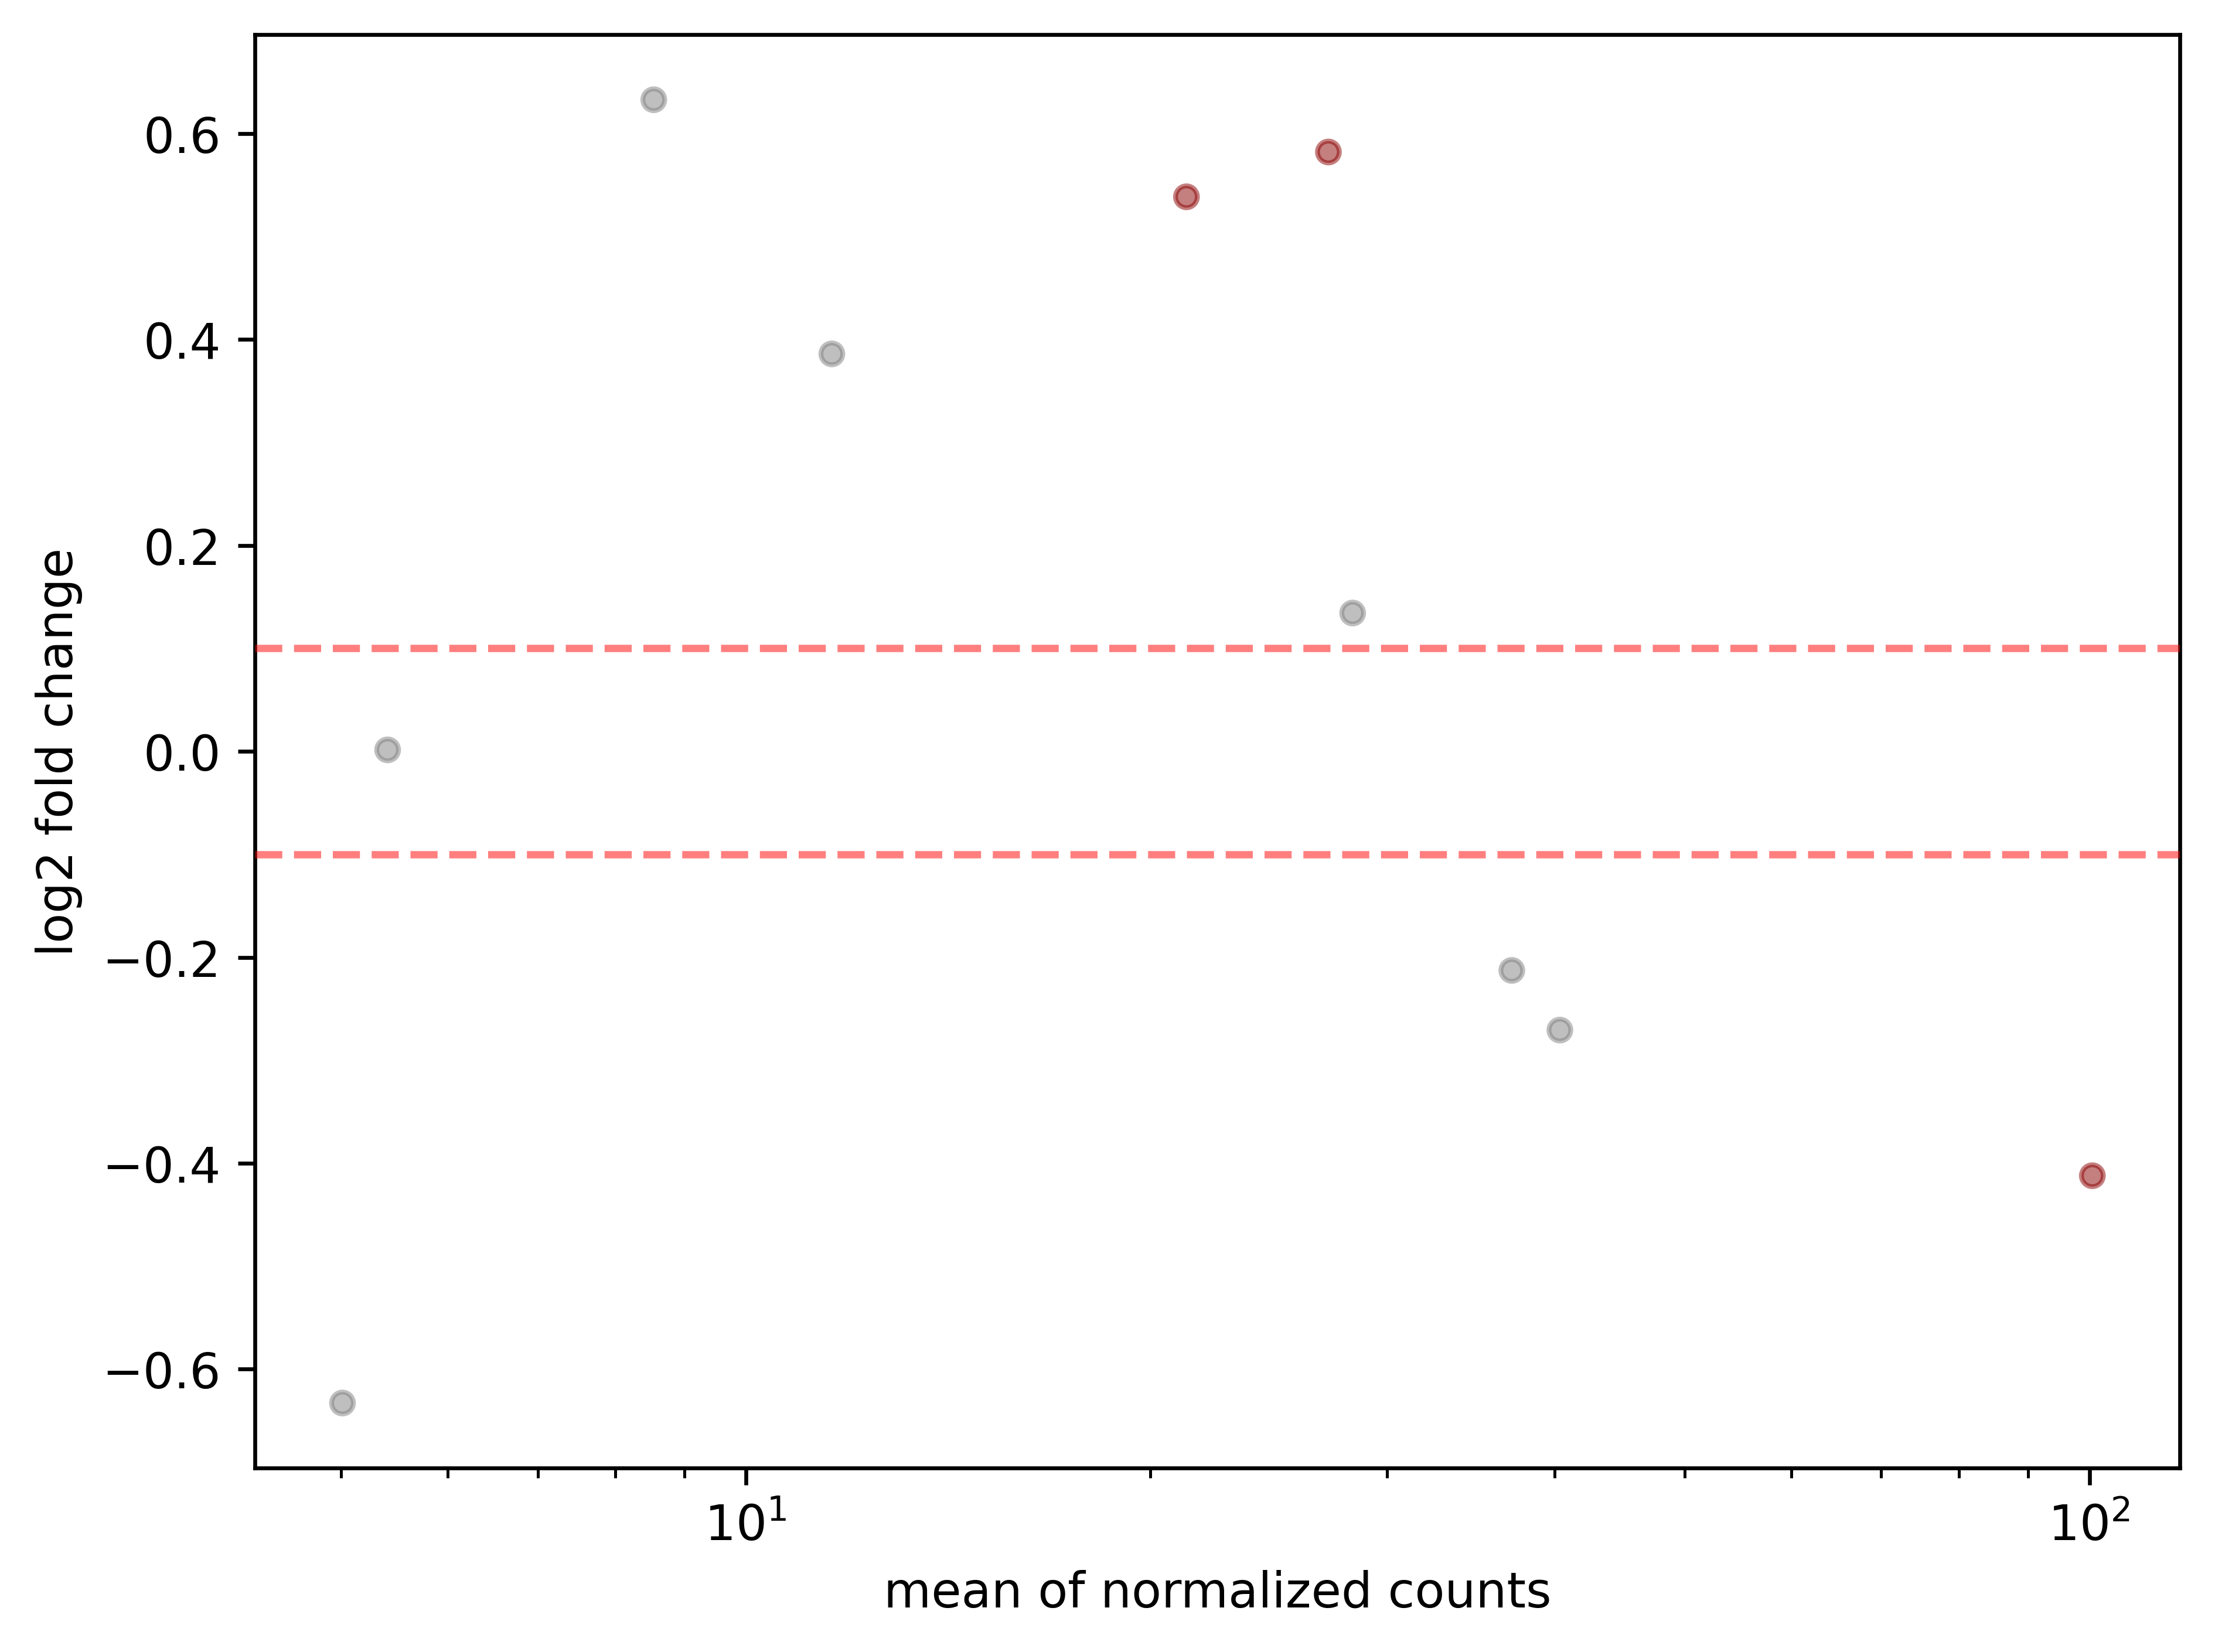

In [23]:
stat_res.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
stat_res.plot_MA(s=20)

## LFC shrinkag

出于可视化或后处理的目的，可能适合执行LFC shrinkage。这是由`lfc_shrinkage()`方法实现的

In [24]:
stat_res.lfc_shrink(coeff="condition_B_vs_A")

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "shrunk_stat_results.pkl"), "wb") as f:
        pkl.dump(stat_res, f)

Shrunk log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.408253  0.294276  1.842998  0.065329  0.142223
gene2    21.281239        0.480145  0.151201  2.924404  0.003451  0.017256
gene3     5.010123       -0.396066  0.300796 -1.804763  0.071112  0.142223
gene4   100.517961       -0.374191  0.118703 -2.630904  0.008516  0.028386
gene5    27.142450        0.521487  0.156210  3.116020  0.001833  0.017256
gene6     5.413043        0.000716  0.239203  0.000000  1.000000  1.000000
gene7    28.294023        0.103421  0.141496  0.229004  0.818866  0.909851
gene8    40.358344       -0.226288  0.133477 -1.251130  0.210887  0.346086
gene9    37.166183       -0.175746  0.129138 -0.845931  0.397591  0.496989
gene10   11.589325        0.239935  0.231986  1.169357  0.242260  0.346086


Fitting MAP LFCs...
... done in 0.01 seconds.



In [26]:
stat_res.dds

AnnData object with n_obs × n_vars = 100 × 10
    obs: 'condition', 'group'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks'

> 运行`lfc_shrink()`将用`shrunk`值覆盖`DeseqStats`日志折叠更改(和标准错误)。这可以使用`shrunk_LFCs `标志来检查。



In [27]:
print(stat_res.shrunk_LFCs)

True


## 多因素分析

到目前为止，我们只使用了`metadata`的`condition`列，该列将样本分为 `condition A`和`B`。`metadata`包含第二列，根据`group X`和`group Y`将样本分开。

In [28]:
print(metadata)

          condition group
sample1           A     X
sample2           A     Y
sample3           A     X
sample4           A     Y
sample5           A     X
...             ...   ...
sample96          B     Y
sample97          B     X
sample98          B     Y
sample99          B     X
sample100         B     Y

[100 rows x 2 columns]


多因素分析的目标是使用两个变量来拟合lfc。

### 读取计数建模

In [29]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors=["group", "condition"],
    refit_cooks=True,
    inference=inference,
)

dds

AnnData object with n_obs × n_vars = 100 × 10
    obs: 'condition', 'group'
    obsm: 'design_matrix'

> 默认情况下，列表中的最后一个变量(这里是“condition”)将显示lfc和p值，但在以后执行统计分析时可能会更改。

对于单因素分析，我们使用`deseq2()`方法拟合`分散度`和`lfc`。

In [30]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.



现在，如果我们打印`log fold`更改，除了截距之外，我们将有两列:一列对应于`group`变量，另一列对应于`condition`。

In [31]:
print(dds.varm["LFC"])

        intercept  group_Y_vs_X  condition_B_vs_A
gene1    1.560313      0.525572          0.507013
gene2    2.812255      0.079229          0.371026
gene3    2.059577     -0.602606         -0.467002
gene4    4.919837     -0.385197         -0.293527
gene5    2.973802      0.194078          0.407582
gene6    1.846061     -0.352410         -0.013510
gene7    3.235967      0.106773          0.093654
gene8    3.640464      0.270819         -0.188248
gene9    3.645334      0.074474         -0.148346
gene10   2.136670      0.303009          0.270003


## 统计分析

`p`值与前面一样，使用`summary()`方法从`DeseqStats`对象计算，并使用一个新的重要参数:对比度。它是一个由三个字符串组成的列表，格式为`["variable"， " testing level"， "reference level"]`，它决定了我们要为哪个变量计算`lfc`和`pvalue`。例如，为了比较`条件B`和`条件A`，我们设置`contrast=["condition"， "B"， "A"]`。

In [32]:
dds

AnnData object with n_obs × n_vars = 100 × 10
    obs: 'condition', 'group'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [33]:
stat_res_B_vs_A = DeseqStats(dds, contrast=["condition", "B", "A"], 
                             inference=inference)


In [34]:
stat_res_B_vs_A.dds

AnnData object with n_obs × n_vars = 100 × 10
    obs: 'condition', 'group'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [35]:
stat_res_B_vs_A.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.731466  0.286275  2.555117  0.010615  0.026538
gene2    21.281239        0.535278  0.149824  3.572711  0.000353  0.001178
gene3     5.010123       -0.673742  0.287399 -2.344269  0.019064  0.038129
gene4   100.517961       -0.423471  0.106221 -3.986711  0.000067  0.000592
gene5    27.142450        0.588016  0.152758  3.849332  0.000118  0.000592
gene6     5.413043       -0.019490  0.307845 -0.063313  0.949518  0.949518
gene7    28.294023        0.135114  0.149561  0.903410  0.366308  0.407009
gene8    40.358344       -0.271584  0.131512 -2.065084  0.038915  0.064858
gene9    37.166183       -0.214018  0.132989 -1.609288  0.107553  0.139684
gene10   11.589325        0.389532  0.244929  1.590388  0.111747  0.139684


... done in 1.11 seconds.



正如我们所看到的，虽然我们比较的是相同的队列(条件B和条件A)，但结果与单因素分析不同。这是因为模型同时使用来自`condition`变量和`group`的信息。

现在让我们根据组` group Y`与`X`计算差分表达式。为此，我们使用`contrast=["group"， "Y"， "X"]`从相同的`DeseqDataSet`创建一个新的`DeseqStats`，并再次运行分析。

In [36]:
stat_res_Y_vs_X = DeseqStats(dds, 
                             contrast=["group", "Y", "X"], 
                             inference=inference)
stat_res_Y_vs_X.summary()

Log2 fold change & Wald test p-value: group Y vs X
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
gene1     8.541317        0.758241  0.286328  2.648155  8.093232e-03  0.020233
gene2    21.281239        0.114304  0.149771  0.763189  4.453508e-01  0.445351
gene3     5.010123       -0.869376  0.287516 -3.023748  2.496642e-03  0.009903
gene4   100.517961       -0.555721  0.106222 -5.231721  1.679390e-07  0.000002
gene5    27.142450        0.279995  0.152731  1.833256  6.676450e-02  0.123874
gene6     5.413043       -0.508421  0.307951 -1.650981  9.874255e-02  0.141061
gene7    28.294023        0.154041  0.149565  1.029927  3.030443e-01  0.378805
gene8    40.358344        0.390709  0.131520  2.970732  2.970913e-03  0.009903
gene9    37.166183        0.107443  0.132982  0.807956  4.191157e-01  0.445351
gene10   11.589325        0.437149  0.244955  1.784611  7.432438e-02  0.123874


Running Wald tests...
... done in 0.01 seconds.



## LFC shrinkage (多因素)
在多因素设置中，LFC shrinkage 的工作原理与单因素设置相同，但只会根据DeseqStats对象的`contrast`参数shrinkage  LFC。

In [37]:
stat_res_B_vs_A.lfc_shrink(coeff="condition_B_vs_A")

Shrunk log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.526936  0.299297  2.555117  0.010615  0.026538
gene2    21.281239        0.479377  0.150834  3.572711  0.000353  0.001178
gene3     5.010123       -0.463492  0.296136 -2.344269  0.019064  0.038129
gene4   100.517961       -0.394989  0.106316 -3.986711  0.000067  0.000592
gene5    27.142450        0.531655  0.154061  3.849332  0.000118  0.000592
gene6     5.413043       -0.008636  0.241570 -0.063313  0.949518  0.949518
gene7    28.294023        0.106695  0.141879  0.903410  0.366308  0.407009
gene8    40.358344       -0.233346  0.129070 -2.065084  0.038915  0.064858
gene9    37.166183       -0.180064  0.129246 -1.609288  0.107553  0.139684
gene10   11.589325        0.251471  0.233140  1.590388  0.111747  0.139684


Fitting MAP LFCs...
... done in 0.01 seconds.

